In [39]:
from roi import equity, external, utilities, macro, metrics, cost, surveys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# make figures readable by humans instead of mice
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

__Section 1: Setup__

This notebook provides some simple instruction in many of the basic methods offered by the ROI Toolkit. Below, we import two files containing fake simulated data. The code to create these files lives in the `testing` directory under the top level of the `roi-toolkit` repo.

In [3]:
bls_api_key = "c8803d0ba66c4592b8b0eff68ac9ebb0" # BLS API Key - free and easy to get

In [4]:
data = pd.read_csv("testing/testing-data/test_microdata.csv") # Fake student-level data

In [5]:
programs = pd.read_csv("testing/testing-data/programs.csv") # Fake program-level data

Here we take a look at the sample data. It contains joined educational and wage records, with one row for each individual. This fake data includes only two earnings columns, `earnings_start` and `earnings_end`. In this data, these columns denote annualized individual earnings, denoted in denominal dollars, at some set periods before and after program entry and exit, e.g. the final quarter before entry and the first quarter after.

Ideally, in real data you'll have many of these columns—for example, at 1, 5, and 10 years after program completion. All of the steps in this notebook can be repeated with multiple "after" columns; in the example, we use only one.

In [6]:
data.head()

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,employed_at_start,state,full_address,Address,City,State,Zip,id,start_month,end_month
0,1,White,Male,46027.000,91781.300,25,Electrical Engineering,2014,2016,0,...,1,8,1647 COURT STREET REDDING CA 96001,1647 COURT STREET,REDDING,CA,96001.000,5335,9,6
1,2,White,Male,41976.000,66896.700,25,Electrical Engineering,2017,2025,0,...,1,8,NaN,NaN,NaN,NaN,nan,8340,9,6
2,3,White,Male,61396.000,74524.600,51,Electrical Engineering,2014,2019,0,...,1,8,690 MEDICAL PARK DRIVE AIKEN SC 29801,690 MEDICAL PARK DRIVE,AIKEN,SC,29801.000,13875,8,7
3,4,White,Male,34089.000,92032.900,18,Electrical Engineering,2018,2022,0,...,1,8,NaN,NaN,NaN,NaN,nan,1201,9,5
4,5,White,Male,57897.000,79573.600,35,Electrical Engineering,2011,2013,0,...,1,8,1547 NORTH COAST HWY NEWPORT OR 97365,1547 NORTH COAST HWY,NEWPORT,OR,97365.000,15397,10,6


__Section 2: Equity analysis__

There are four key equity metric classes in the `equity` submodule: `Gini`, `Theil_T`, `Theil_L`, and `Variance_Analysis`. Each method inherits from the `Metric()` parent class. These methods can be supplied with numpy arrays, but the easiest way to use them is with the `.from_dataframe` factory method, demonstrated below with the following syntax:

`from_dataframe(frame, group_columns, value_column, sample=False)`

The `sample` argument uses only a random subset (without replacement) of the data in order to calculate the equity metric. This is really only necessary with the `Gini()` class, which needs to do pairwise comparisons across all observations, and therefore runs in factorial time.

In [8]:
gini = equity.Gini.from_dataframe(data, 'gender', 'earnings_end', sample = 2000) # library method
gini.calculate()

/Users/mattlerner/roi/sbir-roi/roi/equity.py:77: UserWarning: When sample == True, Metric() will use the value of sample to create a random subset of values that it will use for all calculations. This number will be stored as attribute .samplesize.
  warnings.warn("When sample == True, Metric() will use the value of sample to create a random subset of values that it will use for all calculations. This number will be stored as attribute .samplesize.")
/Users/mattlerner/roi/sbir-roi/roi/equity.py:61: UserWarning: Data passed contains 103 NA values. All equity metrics are calculated by ignoring NA values, in effect dropping them. Please ensure that you have a strategy for dealing with these missing values. If values are not missing at random, e.g. if individuals with missing values have common traits, then ALL METRICS calculated will be biased.
  warnings.warn("Data passed contains {} NA values. All equity metrics are calculated by ignoring NA values, in effect dropping them. Please ensur

Above, you'll see the verbose warnings that are common to the `roi-toolkit` module. Users are kept appraised, as much as possible, about what's going on behind the scenes. Warnings should be read, and ignored only after they've been understood.

The `.calculate()` method attached to each equity class does the calculation work, as you might expect. It creates several new attributes of the class instance that can be used for equity analysis. The `.viz` attribute, for example, contains a Seaborn box plot allowing the analyst to visualize differences between groups.

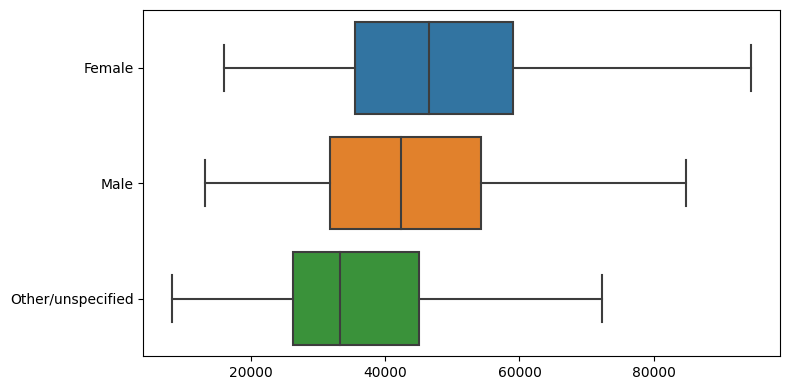

In [9]:
gini.viz

One relatively uncommon feature of the equity classes included in the `equity` submodule is the inclusion of the `.ratio` attribute.

Each of the four equity classes included in the submodule is broadly decomposable into "within" and "between"-group inequality. The values for these subcomponents are accessible (after `.calculate()` is run) at the instance attributes `.within` and `.between`, and their sum--the value of the calculated index--is accessible at `.overall`.

The `.ratio` attribute is simply the ratio of `.between` to `.overall`: it takes a value between 0 and 1 and is broadly interpretable as the amount (the percentage) of variation that is accounted for by cross-group--instead of within-group variation.

Values closer to 1 indicate that greater variation in, say, wages, is accounted for by someone's group membership. Depending on the grouping variable provided, this may or may not be indicative of an equity issue. Take an extreme case: a value of 1 and a grouping variable of `SES`. In this scenario, all the variation in program graduate wages is accounted for by student socioeconomic status. This would mean that, no matter what classes they take, what their personal aptitude is, or what grades they get, differences in student earnings are wholly accounted for by SES. Many analysts would take this to be a significant equity concern

In [10]:
gini.ratio

0.3331446175942655

__Section 3: Geocode addresses__

In order to use information about particular geographic areas in the United States, it may be necessary to u.s. __geocodes__. Geocodes are used by the U.S. Census in order to uniquely identify areas as small as a census tract. The `external.Census.get_batch_geocode()` method takes a dataframe and queries the U.S. Census geocoding API to get geocodes for the addresses included in the frame.

This method uses the [geocoding API](https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.pdf) from the census to get unique twelve-digit IDs that identify specific Census block groups in the U.S. You can find more information on the Census [web site](https://geocoding.geo.census.gov/).

In [13]:
small_data = data.sample(40)

In [14]:
small_data.head()

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,employed_at_start,state,full_address,Address,City,State,Zip,id,start_month,end_month
2190,2191,Asian or Pacific Islander,Male,30353.000,nan,53,Art History,2014,2019,60,...,0,8,NaN,NaN,NaN,NaN,nan,620,8,7
3134,3135,Asian or Pacific Islander,Other/unspecified,20183.000,27948.510,18,Biology,2013,2016,60,...,1,8,"121 E. CEDAR STREET, PO BOX 100550 FLORENCE SC...","121 E. CEDAR STREET, PO BOX 100550",FLORENCE,SC,29501.000,15210,9,5
9719,9720,Other,Male,26787.000,46582.200,23,Economics,2014,2015,111,...,0,8,2029 ASHEVILLE HIGHWAY HENDERSONVILLE NC 28739,2029 ASHEVILLE HIGHWAY,HENDERSONVILLE,NC,28739.000,1784,10,6
9723,9724,Other,Male,27723.000,46797.800,38,Economics,2012,2015,111,...,1,8,"5003 HORIZONS DRIVE, SUITE 100 COLUMBUS OH 43220","5003 HORIZONS DRIVE, SUITE 100",COLUMBUS,OH,43220.000,14173,10,7
2377,2378,Other,Other/unspecified,27332.000,28858.775,27,Art History,2018,2020,60,...,0,8,700 RIVER DRIVE FORT BRAGG CA 95437,700 RIVER DRIVE,FORT BRAGG,CA,95437.000,3435,9,5


In [15]:
small_data['geocode'] = external.Census.get_batch_geocode(small_data)

Successfully geocoded 42.5% of 40 passed addresses.
Of successfully matched addresses, 88.24% were exact matches


As you can see, the geocoding method is verbose, telling the user exactly how many addresses were matched and what percentage of those were matched exactly. The method returns a Pandas series which is most easily deployed simply by adding it as a column to the original dataframe, which you can see below.

In [17]:
small_data.head()

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,state,full_address,Address,City,State,Zip,id,start_month,end_month,geocode
2190,2191,Asian or Pacific Islander,Male,30353.000,nan,53,Art History,2014,2019,60,...,8,NaN,NaN,NaN,NaN,nan,620,8,7,
3134,3135,Asian or Pacific Islander,Other/unspecified,20183.000,27948.510,18,Biology,2013,2016,60,...,8,"121 E. CEDAR STREET, PO BOX 100550 FLORENCE SC...","121 E. CEDAR STREET, PO BOX 100550",FLORENCE,SC,29501.000,15210,9,5,
9719,9720,Other,Male,26787.000,46582.200,23,Economics,2014,2015,111,...,8,2029 ASHEVILLE HIGHWAY HENDERSONVILLE NC 28739,2029 ASHEVILLE HIGHWAY,HENDERSONVILLE,NC,28739.000,1784,10,6,370899309002
9723,9724,Other,Male,27723.000,46797.800,38,Economics,2012,2015,111,...,8,"5003 HORIZONS DRIVE, SUITE 100 COLUMBUS OH 43220","5003 HORIZONS DRIVE, SUITE 100",COLUMBUS,OH,43220.000,14173,10,7,
2377,2378,Other,Other/unspecified,27332.000,28858.775,27,Art History,2018,2020,60,...,8,700 RIVER DRIVE FORT BRAGG CA 95437,700 RIVER DRIVE,FORT BRAGG,CA,95437.000,3435,9,5,060450105004


__Section 4: Get SES for each individual with a geocode__

One useful thing you can do with Census geocodes is to join them with datasets that provide geographically-sourced data that can give a clue as to individuals' socioeconomic status.

One such dataset is the [Area Deprivation Index](https://www.neighborhoodatlas.medicine.wisc.edu/) from the University of Wisconsin. The ADI classifies Census block groups on a scale from 1-100, where 100 is the most "deprived." We use ADI here as a proxy for socioeconomic status.

The ROI Toolkit is packaged with the latest ADI dataset. When you call the `equity.ADI()` method below, the module loads up the data and then separates the block groups into five quintiles of deprivation, with the highest quintile ("80-100") being the most deprived.

In [19]:
adi = equity.ADI()

On running the `.get_quintile_for_geocodes_frame()` method, you'll get back a Pandas series in the same order as the original dataframe. The method will tell you exactly how many of the rows provided were matched with ADI quintiles. The percentage should match the percentage of addresses that were geocoded above.

In [20]:
small_data['ses'] = adi.get_quintile_for_geocodes_frame(small_data, 'geocode') # library method

Geocode merge: Merged 17 of 40 observations in input dataframe (42.5%)


In [22]:
small_data.sample(10)

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,full_address,Address,City,State,Zip,id,start_month,end_month,geocode,ses
4264,4265,Other,Other/unspecified,32331.000,40334.030,34,Art History,2011,2014,73,...,NaN,NaN,NaN,NaN,nan,10003,10,7,,NaN
2377,2378,Other,Other/unspecified,27332.000,28858.775,27,Art History,2018,2020,60,...,700 RIVER DRIVE FORT BRAGG CA 95437,700 RIVER DRIVE,FORT BRAGG,CA,95437.000,3435,9,5,060450105004,80-100
2570,2571,White,Other/unspecified,30780.000,44509.570,18,Economics,2014,2016,60,...,NaN,NaN,NaN,NaN,nan,11856,8,6,,NaN
11961,11962,Other,Other/unspecified,19847.000,18384.480,25,Anthropology,2013,2018,123,...,2959 WEST 95TH STREET EVERGREEN PARK IL 60805,2959 WEST 95TH STREET,EVERGREEN PARK,IL,60805.000,1623,8,7,170318218002,40-60
14108,14109,Black,Male,37930.000,36852.200,35,French Literature,2015,2016,124,...,NaN,NaN,NaN,NaN,nan,7927,8,7,,NaN
2699,2700,Asian or Pacific Islander,Male,34055.000,35169.600,32,Anthropology,2014,2015,60,...,NaN,NaN,NaN,NaN,nan,8703,10,5,,NaN
14890,14891,Asian or Pacific Islander,Male,41165.000,48969.800,29,Art History,2012,2014,125,...,NaN,NaN,NaN,NaN,nan,15511,9,6,,NaN
11100,11101,White,Female,20763.000,51185.640,36,Electrical Engineering,2012,2015,123,...,"16600 SHERMAN WAY, STE 200 VAN NUYS CA 91406","16600 SHERMAN WAY, STE 200",VAN NUYS,CA,91406.000,12927,9,7,060371321023,0-20
373,374,White,Female,33631.000,41959.170,61,Art History,2016,2020,0,...,"321 FORTUNE BOULEVARD, SUITE 106B MILFORD MA 1757","321 FORTUNE BOULEVARD, SUITE 106B",MILFORD,MA,1757.000,13712,10,5,250277442003,20-40
283,284,White,Male,40174.000,54447.800,21,Art History,2012,2018,0,...,2101 VISTA PARKWAY SUITE 102 WEST PALM BEACH F...,2101 VISTA PARKWAY SUITE 102,WEST PALM BEACH,FL,33411.000,5450,10,5,120990078362,40-60


__Section 5: Check out SES equity concerns__

Once you've classified individuals into SESs, you can use the SES as a grouping variable-- another axis on which to investigate equity concerns. Here we use the `Theil_T()` method from the `equity` submodule. As it is an instance of the `Metric()` parent class, it has all of the same attributes and methods. You can read more about the Theil index on [Wikipedia](https://en.wikipedia.org/wiki/Theil_index).

In [23]:
theil_t = equity.Theil_T.from_dataframe(small_data, 'ses', 'earnings_end') # library method

In [24]:
theil_t.calculate()

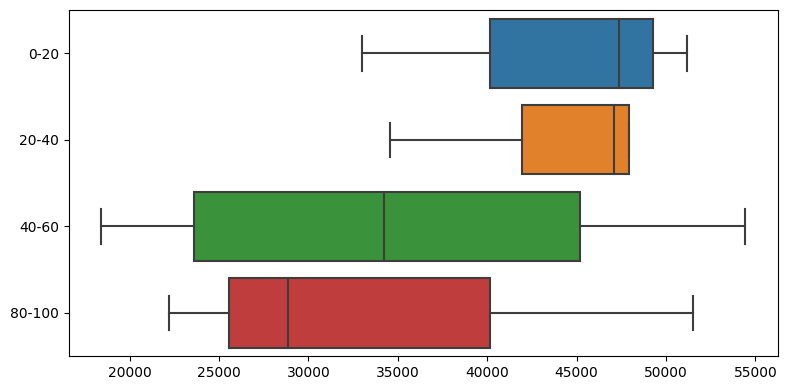

In [25]:
theil_t.viz

In [26]:
theil_t.ratio

0.20680992161391945

Again, the ratio attribute here tells the analyst how much variation is attributable to SES.

__Section 6: Calculate graduate wage summary statistics__

Another useful think that `roi-toolkit` allows you to do is adjust for inflation. This can be very important when you have multiple years of data. Students' starting earnings will typically be expressed in nominal dollars. Over a long enough timespan, this can make a big difference for equity and return calculations. A student making \\$20,000 in 2010 was making almost \\$24,000 in 2020 dollars - a 20% difference.

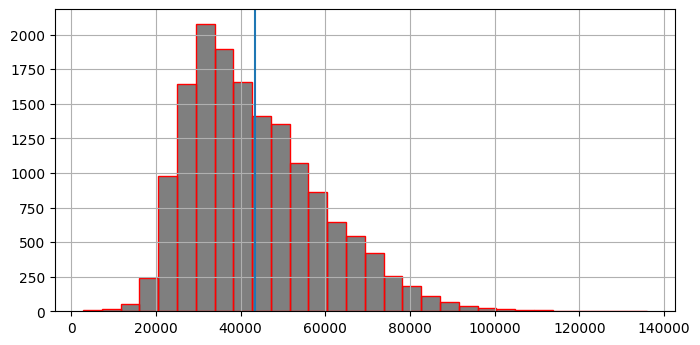

In [27]:
# Nothing toolkit-specific here. Just getting the distribution for unadjusted wages

fig, ax = plt.subplots()
data['earnings_end'].hist(ax=ax, edgecolor="red", fc=(0, 0, 0, 0.5), bins=30)
plt.axvline(x=np.mean(data['earnings_end']))

The `utilities.multiple_describe()` is a useful wrapper for Pandas grouping and aggregation methods. It takes a dataframe, a grouping column, and a value column, and returns a dataframe containing summary statistics for the provided value at the group level.

In [22]:
utilities.multiple_describe(data, 'program', 'earnings_end') # library method

,program,n,mean,median,sd,min,max
0,Anthropology,2288.000,31540.395,31381.600,6542.271,2817.240,63547.440
1,Art History,2370.000,42312.370,41632.800,9460.368,4287.800,75483.430
2,Biology,2404.000,35848.828,35303.220,7838.359,6602.715,64873.710
3,Economics,2327.000,54705.240,54158.720,11048.693,14172.620,102118.940
4,Electrical Engineering,2386.000,65698.580,64849.900,14206.740,20139.900,135887.290
5,French Literature,2339.000,27875.583,27687.748,5501.041,6088.635,50285.620
6,Philosophy,2297.000,46128.218,45486.000,10275.570,14191.200,96564.600


__Adjust wages for inflation__

Methods to adjust for inflation and fetch historical time series are in the `macro.BLS_Ops()` class, since the data necessary to make these calculations comes originally from the U.S. Bureau of Labor Statistics API. Instantiating the class takes a moment, since it has to read in the BLS output that comes packaged with the module (and that can be refreshed with `setup.py`). 

The `bls.adjust_to_current_dollars()` method takes a dataframe, a year column in format YYYY (in this case `program_end`) and a value column.

In [40]:
bls = macro.BLS_Ops()
data['earnings_end_adjusted'] = bls.adjust_to_current_dollars(data, 'program_end', 'earnings_end') # library method

Latest CPI year in provided BLS data is 2018.0: All dollars being adjusted to 2018.0 dollars.
Years in provided dataframe for which there is no data in the provided CPI frame:

{2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028}


/Users/mattlerner/roi/sbir-roi/roi/macro.py:58: UserWarning: Value column earnings_end contains 821 NA values (5.0%) of total.
  warnings.warn("Value column {} contains {} NA values ({}%) of total.".format(value_column_name, value_nas, round(100*value_nas/len(frame_),2)))
/Users/mattlerner/roi/sbir-roi/roi/macro.py:71: UserWarning: 5515 rows in column program_end could not be merged with provided CPI data. Please note that (1) the BLS API provides only up to 20 years of data; if you want to use more, you will have to manually combine multiple queries. (2) We do not recommend using more than ten years of historical data in calculations.
  warnings.warn("{} rows in column {} could not be merged with provided CPI data. Please note that (1) the BLS API provides only up to 20 years of data; if you want to use more, you will have to manually combine multiple queries. (2) We do not recommend using more than ten years of historical data in calculations.".format(unmerged_len, year_column_name))

Once again, the module provides a verbose response, warning the user when the data contains years that can't be adjusted (in this case because they're bizarrely in the future-- this can be a data quality issue!).

In [41]:
data[['program_end','earnings_end','earnings_end_adjusted']].sample(10)

,program_end,earnings_end,earnings_end_adjusted
7580,2017,nan,nan
13231,2017,56959.540,58349.149
12584,2022,62106.000,nan
7719,2018,39197.950,39197.950
684,2019,41903.400,nan
1038,2018,24618.040,24618.040
11612,2015,54890.220,58155.739
16387,2014,41328.360,43840.102
15165,2020,42124.600,nan
14421,2015,40346.400,42746.681


__Recalculate average graduate wage by program__

Here we plot the distribution of nominal wages against inflation-adjusted wages. As you can see, the mean wage doesn't change too much -- but the overall distribution does change, which is important. If the composition of programs has changed over time, inflation adjustment can be vital for drawing conclusions about equity. For example, if a program has substantially more low-SES students than it did ten years ago, failing to adjust for inflation could make those students appear better off than they actually are (because they're being compared to nominally lower-earning students many years ago).

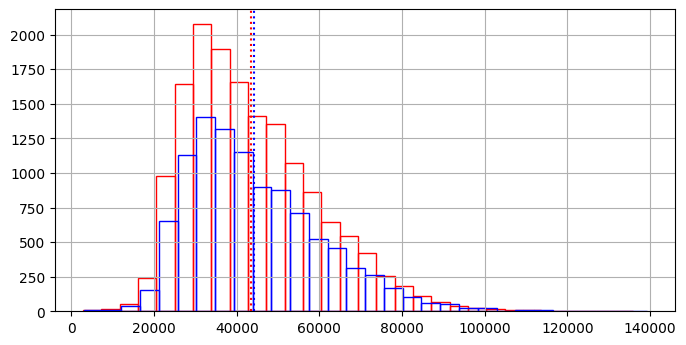

In [42]:
fig, ax = plt.subplots()

# unadjusted
data['earnings_end'].hist(ax=ax, edgecolor="red", fc=(0, 0, 0, 0), bins=30)
plt.axvline(x=np.mean(data['earnings_end']), color="red", linestyle=":")

# adjusted
data['earnings_end_adjusted'].hist(ax=ax, edgecolor="blue", fc=(0, 0, 0, 0), bins=30)
plt.axvline(x=np.mean(data['earnings_end_adjusted']), color="blue", linestyle=":")

__Section 7: Earnings premium__

__Calculate earnings premium - Simple way__

The most simple earnings-related measurement that analysts might be concerned with is the __earnings premium__, defined here as the additional wages attributable to participation in a given program. Here we do that in the simplest way possible: by subtracting nominal post-program earnings from nominal pre-program earnings.

In [43]:
data['earnings_change'] = data['earnings_end'] - data['earnings_start']

In [44]:
utilities.multiple_describe(data, 'program', 'earnings_change') # library method

,program,n,mean,median,sd,min,max
0,Anthropology,2288.000,1492.413,1748.180,7514.140,-46000.200,41005.440
1,Art History,2370.000,13117.589,13010.150,8743.259,-49156.200,54181.100
2,Biology,2404.000,5538.174,5503.500,7822.369,-28674.700,54911.950
3,Economics,2327.000,24685.001,24170.200,10529.107,-15061.260,77500.780
4,Electrical Engineering,2386.000,36063.777,35277.400,13514.743,-21673.600,112955.900
5,French Literature,2339.000,-2656.493,-2261.950,6824.586,-62843.250,36069.590
6,Philosophy,2297.000,16914.652,16949.000,9296.036,-22386.120,61526.600


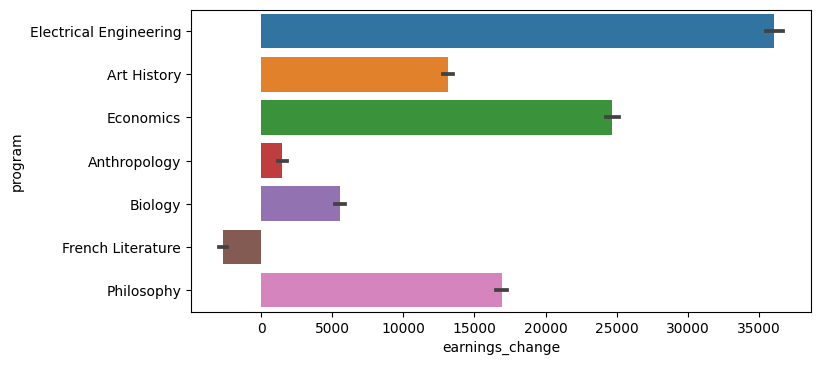

In [45]:
sns.barplot(x="earnings_change", y="program", data=data, estimator=np.mean)

__Calculate earnings premium - Fancy way__

One of the central concerns about calculating premiums in the above "simple" way is the necessity of adjusting for macroeconomic trends. If the average difference between post- and pre-program earnings for participants in a given program is 4%, you might conclude that the program improves earning power by 4%. But if, over the time students spent in a program, overall wages in their region go up by 5%, then in fact the program has actually "hurt" students' earning power by 1%.

 `roi-toolkit` offers a method to simply correct for trend. The `BLS_Ops.wage_change()` method takes in a dataframe of student states, program start and end dates (in 'YYYY-MM' format), and for each student returns the macroeconomic change in wages for their region over the time period provided.
 
Analysts should be mindful that the `wage_change()` method 

In [46]:
data['year_month_entry'] = data['program_start'].astype(str) + '-' + data['start_month'].astype(str).str.zfill(2)
data['year_month_exit'] = data['program_end'].astype(str) + '-' + data['end_month'].astype(str).str.zfill(2)

In many contexts, you'll need state FIPS codes (e.g. "08") instead of postal codes (e.g. "CO"). This is one of those contexts. Luckily, the toolkit offers the `utilities.State_To_FIPS_series()` method to help you easily translate.

In [47]:
data['state_fips'] = utilities.State_To_FIPS_series(data['State'])

In [48]:
data['macro_wage_change'] = bls.wage_change(data, 'state_fips','year_month_entry','year_month_exit')

/Users/mattlerner/roi/sbir-roi/roi/macro.py:202: UserWarning: Series passed as argument state_code contains invalid values for state codes. Please refer to https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm for valid codes. Use utilities.State_To_FIPS_series() to convert postal codes to FIPS.
  warnings.warn("Series passed as argument state_code contains invalid values for state codes. Please refer to https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm for valid codes. Use utilities.State_To_FIPS_series() to convert postal codes to FIPS.")


In [49]:
data.sample(10)

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,Zip,id,start_month,end_month,earnings_change,year_month_entry,year_month_exit,state_fips,earnings_end_adjusted,macro_wage_change
11452,11453,White,Other/unspecified,36435.000,46395.635,18,Art History,2010,2014,123,...,nan,3096,10,7,9960.635,2010-10,2014-07,nan,49215.342,nan
8655,8656,White,Male,26094.000,20468.000,47,French Literature,2018,2023,92,...,92373.000,5731,10,6,-5626.000,2018-10,2023-06,06,nan,nan
3283,3284,White,Female,29889.000,30227.890,24,French Literature,2015,2019,60,...,56359.000,11602,8,7,338.890,2015-08,2019-07,27,nan,6346.600
8406,8407,White,Male,42509.000,37719.000,29,Biology,2013,2016,92,...,34471.000,13898,10,5,-4790.000,2013-10,2016-05,12,39465.508,2468.960
13165,13166,White,Female,21013.000,35120.250,18,Art History,2017,2020,124,...,nan,12320,9,7,14107.250,2017-09,2020-07,nan,nan,nan
14384,14385,Black,Male,39676.000,66086.400,45,Philosophy,2014,2018,124,...,nan,15613,9,7,26410.400,2014-09,2018-07,nan,66086.400,nan
1086,1087,White,Male,24942.000,31663.800,32,Biology,2014,2015,0,...,nan,4888,8,7,6721.800,2014-08,2015-07,nan,33547.537,nan
7925,7926,White,Female,41731.000,53892.300,39,Economics,2011,2015,92,...,76017.000,8879,8,6,12161.300,2011-08,2015-06,48,57098.451,3635.840
4243,4244,Asian or Pacific Islander,Other/unspecified,41654.000,49950.505,18,Art History,2010,2017,73,...,48075.000,2485,8,5,8296.505,2010-08,2017-05,26,51169.119,4125.680
15520,15521,Black,Female,23696.000,33102.080,61,Anthropology,2017,2022,125,...,78595.000,14317,9,5,9406.080,2017-09,2022-05,48,nan,nan


Once you've gotten the macro-level wage change, you can simply subtract it from the nominal earnings change in order to get a trend-adjusted wage change.

In [50]:
data['trend_adjusted_change'] = data['earnings_change'] - data['macro_wage_change']

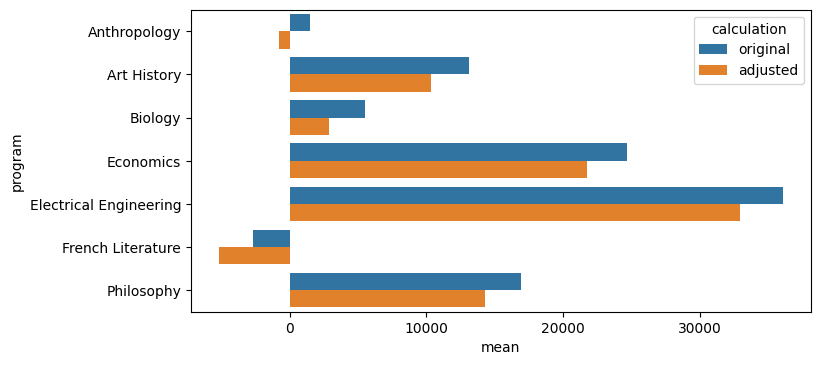

In [51]:
original_summary = utilities.multiple_describe(data, 'program', 'earnings_change')
adjusted_summary = utilities.multiple_describe(data, 'program', 'trend_adjusted_change')
original_summary['calculation'] = "original"
adjusted_summary['calculation'] = "adjusted"

sns.barplot(x="mean", y="program", hue="calculation", data=pd.concat([original_summary, adjusted_summary]))

__Calculate earnings premium - VERY fancy way__

Perhaps the most novel part of the `roi-toolkit` package is the `metrics.Earnings_Premium()` class. This class requires a dataframe and several columns. Most of these columns are self-explanatory (please see the [docstrings]
(https://github.com/brighthive/roi-toolkit/blob/master/roi/metrics.py)), but the user also needs to supply an `education_level` column containining individuals' education levels __prior__ to program entry. This column needs to match up with [CPS EDUC codes](https://cps.ipums.org/cps-action/variables/EDUC#codes_section).

The backbone of this method is a modified [Mincer earnings function](https://en.wikipedia.org/wiki/Mincer_earnings_function) that is fit on ten years of national-level Current Population Survey data. The complete model is stored in the `roi-toolkit` repo, while its coefficients alone are packaged with the module itself.

For comprehensive background on the Mincer model, please read James Heckman's magisterial [NBER paper](https://www.nber.org/system/files/working_papers/w9732/w9732.pdf) on the topic.

The Mincer model fits a basic log-linear model to estimate the approximate impacts of education and work experience on wages. It provides broad numerical answers to questions such as "For an additional X years of work experience, what percentage raise can a person expect who has Y education and Z previous years in the labor force?"

The Mincer model is not particularly effective at forecasting overall earnings using this data alone: individuals' earnings vary dramatically based on numerous other factors. However, the values of the coefficients on __additional__ education are fairly precisely estimated. In other words, though the Mincer model can't very effectively predict someone's wages if all you know about them is their education and work experience, it can be very useful in helping forecast their wages if you __already know their historical earnings__.

That's how it's used here: for every individual in a dataset, the `metrics.Earnings_Premium()` method uses the Mincer model to predict a counterfactual wage: if, instead of participating in their educational or training program, they'd stayed in the labor force, what would their wage be? The earnings premium is calculated as the difference between their observed post-program wage and their predicted counterfactual wage.

In [52]:
# library method
premium = metrics.Earnings_Premium(data, 'state_fips', 'education_level', 'earnings_start', 'earnings_end', 'program_start', 'program_end', 'age')

/Users/mattlerner/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [53]:
data['predicted_wage'] = premium.predicted_wage
data['earnings_premium'] = premium.full_premium

In [54]:
data.sample(5)

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,end_month,earnings_change,year_month_entry,year_month_exit,state_fips,earnings_end_adjusted,macro_wage_change,trend_adjusted_change,predicted_wage,earnings_premium
13134,13135,Other,Male,34179.000,42249.900,33,Art History,2012,2015,124,...,6,8070.900,2012-08,2015-06,26,44763.424,2792.920,5277.980,39463.487,2786.413
10111,10112,Black,Other/unspecified,23225.000,22868.400,61,Anthropology,2013,2016,111,...,7,-356.600,2013-09,2016-07,nan,23927.279,nan,nan,19485.773,3382.627
15202,15203,White,Female,22376.000,46803.680,54,Economics,2016,2018,125,...,7,24427.680,2016-10,2018-07,48,46803.680,2241.720,22185.960,20746.926,26056.754
10827,10828,Black,Female,34726.000,37235.880,40,Philosophy,2015,2021,111,...,5,2509.880,2015-08,2021-05,06,nan,nan,nan,42246.742,-5010.862
8320,8321,White,Other/unspecified,17815.000,19084.200,18,Anthropology,2014,2018,92,...,7,1269.200,2014-08,2018-07,42,19084.200,4732.520,-3463.320,26820.410,-7736.210


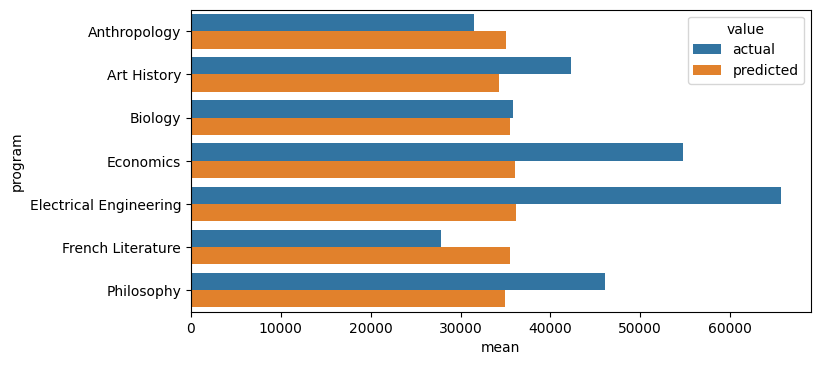

In [55]:
# Mean predicted vs actual wage by program
original_summary = utilities.multiple_describe(data, 'program', 'earnings_end')
adjusted_summary = utilities.multiple_describe(data, 'program', 'predicted_wage')
original_summary['value'] = "actual"
adjusted_summary['value'] = "predicted"

sns.barplot(x="mean", y="program", hue="value", data=pd.concat([original_summary, adjusted_summary]))

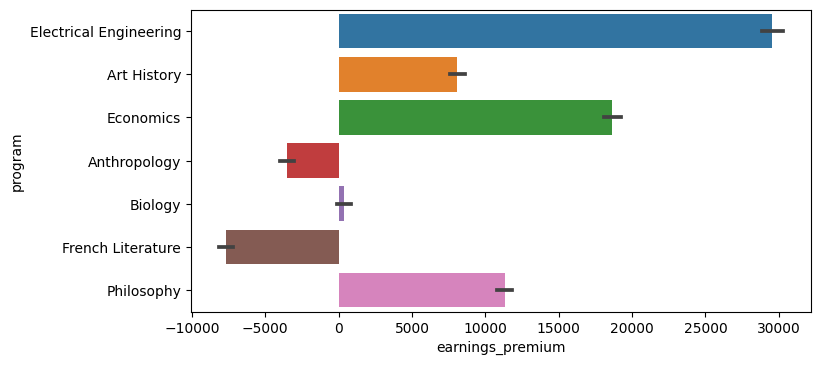

In [56]:
sns.barplot(x="earnings_premium", y="program", data=data, estimator=np.mean)

__Section 8: Calculate employment premium__

Students and decisionmakers may also ask the question: "If I participate in a given program, how much likelier am I to get a job than if I hadn't participated?"

The `metrics.Employment_Likelihood()` method helps to answer that question in the same fashion as the trend-adjusted earnings premium calculated above in Section 7. In addition to YYYY-MM dates of entry and exit, this method also takes two binary variables-- one denoting whether or not an individual was employed before program entry, and one indicating whether they were employed after graduation.

In [42]:
# library method
employment = metrics.Employment_Likelihood(data, 'program', 'year_month_entry', 'year_month_exit', 'employed_at_end', 'employed_at_start', 'state')

/Users/mattlerner/roi/sbir-roi/roi/utilities.py:135: UserWarning: State codes, though integers, should be passed as strings. Something else was passed. Attempting to coerce to string.
  warnings.warn("State codes, though integers, should be passed as strings. Something else was passed. Attempting to coerce to string.")


In [43]:
# library method
premium = employment.employment_premium

Text(0.5, 1.0, 'Average employment premium')

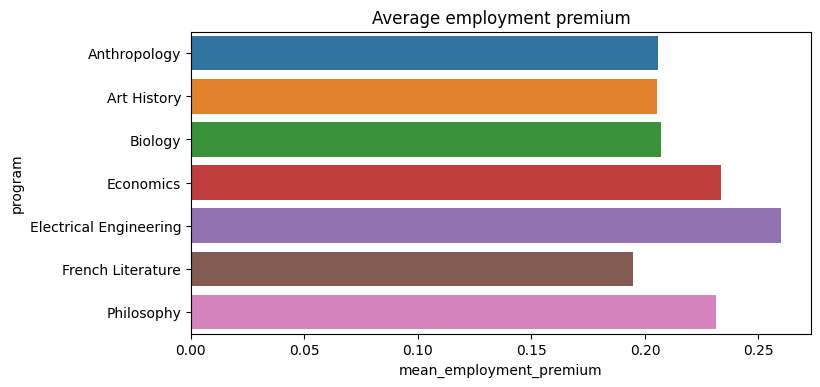

In [44]:
sns.barplot(x="mean_employment_premium", y="program", data=premium).set_title("Average employment premium")

__Calculate time to completion and completion rate statistics__

In [45]:
# library method
completion = metrics.Completion(data, 'program', 'program_start', 'program_end', 'completer')

In [46]:
completion_time = completion.time_to_completion
completion_time

,program,n,mean,median,sd,min,max
0,Anthropology,2288,3.101,3,1.764,-1,10
1,Art History,2370,3.361,3,1.711,0,10
2,Biology,2404,3.192,3,1.725,-1,11
3,Economics,2327,3.713,3,1.792,0,12
4,Electrical Engineering,2386,4.009,4,1.732,0,11
5,French Literature,2339,3.041,3,1.709,-1,10
6,Philosophy,2297,3.527,3,1.713,0,11


In [47]:
completion_rate = completion.completion_rates
completion_rate

,program,n,mean,median,sd,min,max
0,Anthropology,2288,0.669,1,0.471,0,1
1,Art History,2370,0.682,1,0.466,0,1
2,Biology,2404,0.671,1,0.470,0,1
3,Economics,2327,0.634,1,0.482,0,1
4,Electrical Engineering,2386,0.592,1,0.492,0,1
5,French Literature,2339,0.702,1,0.458,0,1
6,Philosophy,2297,0.654,1,0.476,0,1


Text(0.5, 1.0, 'Average time to complete')

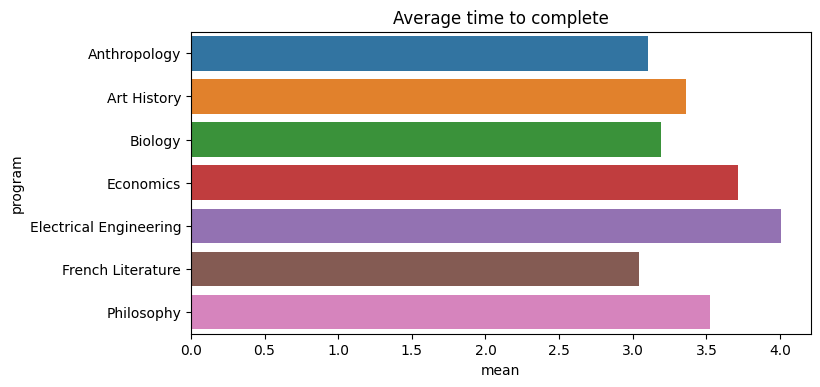

In [48]:
sns.barplot(x="mean", y="program", data=completion_time).set_title("Average time to complete")

Text(0.5, 1.0, 'Average completion rate')

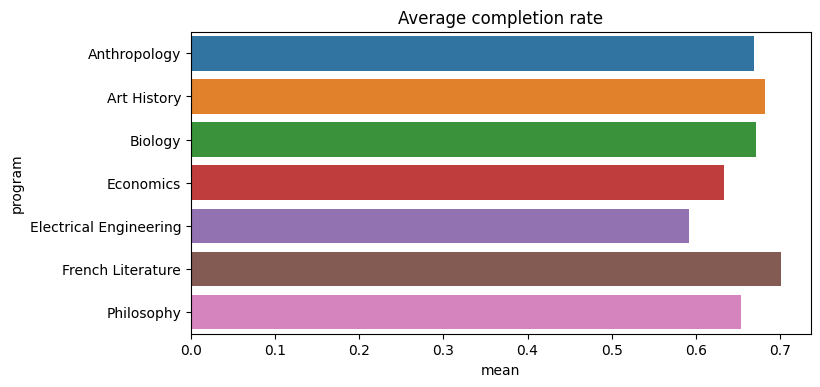

In [49]:
sns.barplot(x="mean", y="program", data=completion_rate).set_title("Average completion rate")

__Try out loan amounts__

In [50]:
data_programs = data.merge(programs, left_on="program", right_on="programs", how="left")
data_programs['total_cost'] = data_programs['cost_per_semester'] * data_programs['length']

# library method
data_programs['period_payment'] = cost.Compound_Interest_Loan.calculate_period_payment(data_programs['total_cost'], 0.05, 10)

In [51]:
data_programs.sample(10)

,Unnamed: 0_x,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,empchange,emp_premium,time_to_completion,Unnamed: 0_y,programs,degree,length,cost_per_semester,total_cost,period_payment
11137,11138,Asian or Pacific Islander,Female,14223.000,44736.010,26,Electrical Engineering,2011,2017,123,...,1,1.052,6,1,Electrical Engineering,BA,8,5000,40000,5180.183
16186,16187,Black,Male,26893.000,46075.200,34,Philosophy,2011,2015,125,...,0,0.038,4,7,Philosophy,BA,8,8000,64000,8288.293
12430,12431,White,Other/unspecified,22315.000,9719.325,58,French Literature,2011,2016,123,...,0,0.043,5,6,French Literature,MA,5,6000,30000,3885.137
11171,11172,Other,Female,34810.000,88697.840,47,Electrical Engineering,2013,2016,123,...,0,0.026,3,1,Electrical Engineering,BA,8,5000,40000,5180.183
14294,14295,Asian or Pacific Islander,Other/unspecified,22351.000,27623.470,18,French Literature,2014,2018,124,...,0,0.013,4,6,French Literature,MA,5,6000,30000,3885.137
12509,12510,White,Male,20251.000,38710.800,18,Philosophy,2012,2016,123,...,0,0.041,4,7,Philosophy,BA,8,8000,64000,8288.293
870,871,Other,Male,25281.000,28027.200,26,Anthropology,2016,2017,0,...,0,0.005,1,4,Anthropology,BA,4,4500,18000,2331.082
12071,12072,White,Female,20957.000,34007.490,29,Biology,2011,2013,123,...,0,0.010,2,5,Biology,AS,3,3000,9000,1165.541
10536,10537,Asian or Pacific Islander,Male,28251.000,29457.400,19,French Literature,2007,2012,111,...,0,-0.042,5,6,French Literature,MA,5,6000,30000,3885.137
12816,12817,Black,Male,31373.000,69584.400,34,Electrical Engineering,2017,2020,124,...,0,nan,3,1,Electrical Engineering,BA,8,5000,40000,5180.183


In [52]:
data_programs['premium_with_payments'] = data_programs['earnings_premium'] - data_programs['period_payment']

In [53]:
summary_w_payments = utilities.multiple_describe(data_programs, 'program', 'premium_with_payments')

Text(0.5, 1.0, 'Return including loan payments')

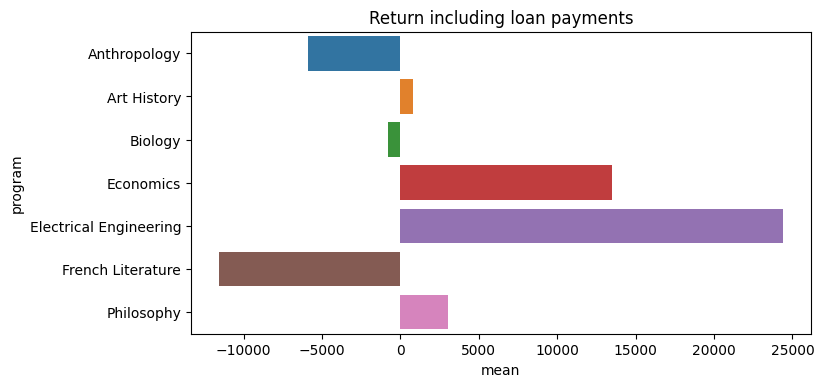

In [54]:
sns.barplot(x="mean", y="program", data=summary_w_payments).set_title("Return including loan payments")

__High school baselines__

In [55]:
cps = surveys.CPS_Ops()

/Users/mattlerner/roi/sbir-roi/roi/utilities.py:135: UserWarning: State codes, though integers, should be passed as strings. Something else was passed. Attempting to coerce to string.
  warnings.warn("State codes, though integers, should be passed as strings. Something else was passed. Attempting to coerce to string.")


In [56]:
# library method
cps.rudimentary_hs_baseline('08', [1, 5, 10])

[15017.630256967966, 21688.246894625805, 34336.28062777556]

In [57]:
states = ['CA','TX','AK','MS','CO','NY','NJ','PA']
fips = utilities.State_To_FIPS_series(states)

State_To_FIPS_series usually takes a pandas series. Something else was passed. Now trying under assumption that passed object is list or array


In [58]:
fips

['06', '48', '02', '28', '08', '36', '34', '42']

In [59]:
baselines = pd.DataFrame([cps.rudimentary_hs_baseline(state, [1, 5, 10]) for state in fips])
baselines['state'] = states
baselines.columns = ['1','5','10','State']

In [60]:
baselines_melted = pd.melt(baselines, id_vars=['State'], var_name="year", value_name="earnings")
baselines_melted['year'] = baselines_melted['year'].astype(int)
baselines_melted['earnings'] = baselines_melted['earnings'].astype(int)

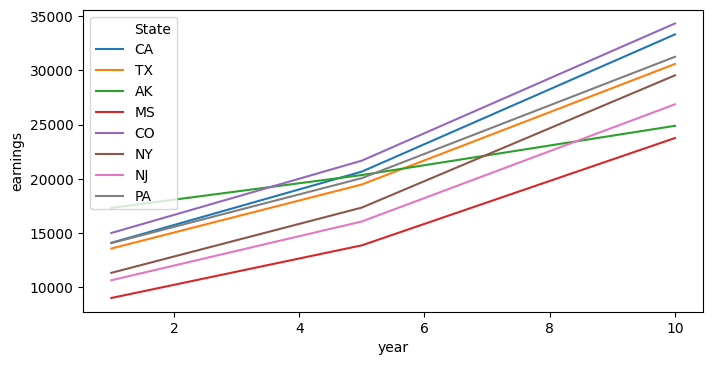

In [61]:
sns.lineplot(data=baselines_melted, x="year", y="earnings", hue="State")

__Completion rate vs earnings premium__

In [62]:
merged_rate_premium = completion_rate.merge(premium, on="program")

[Text(0, 0.5, 'Increased likelihood of employment'),
 Text(0.5, 0, 'Completion rate'),
 Text(0.5, 1.0, 'Completion rate vs employment premium')]

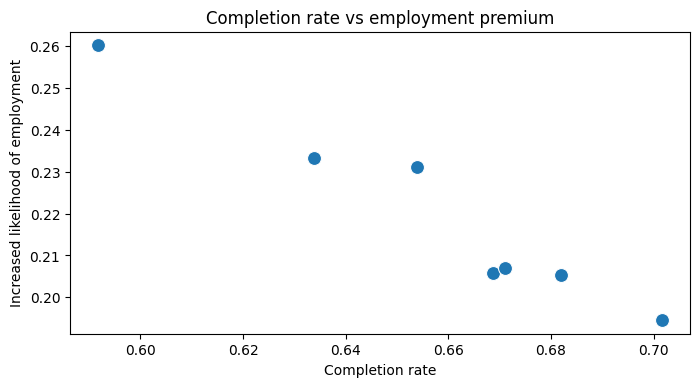

In [63]:
fig, ax = plt.subplots()
sns.scatterplot(data=merged_rate_premium, x="mean", y="mean_employment_premium", ax=ax, s=100)
ax.set(xlabel='Completion rate', ylabel='Increased likelihood of employment', title='Completion rate vs employment premium')